In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [23]:
stocks = input("Enter the ticket symbol (e.g. AAPL or RELIANCE.NS): ").strip().upper()
data = yf.download(stocks, "2020-01-01", "2025-09-18", auto_adjust=True)

Enter the ticket symbol (e.g. AAPL or RELIANCE.NS):  FANG


[*********************100%***********************]  1 of 1 completed


In [24]:
print("Data shape:", data.shape)
print(data.head())
print(data.describe())

Data shape: (1435, 5)
Price           Close       High        Low       Open   Volume
Ticker           FANG       FANG       FANG       FANG     FANG
Date                                                           
2020-01-02  72.897896  73.692575  71.985194  73.448660  1822000
2020-01-03  74.282700  75.337022  73.511624  74.746914  2168500
2020-01-06  74.668228  75.462907  73.936495  75.266205  2018200
2020-01-07  75.864182  75.958601  74.471531  74.471531  2196900
2020-01-08  73.432930  76.257573  72.866426  75.911381  1991100
Price         Close         High          Low         Open        Volume
Ticker         FANG         FANG         FANG         FANG          FANG
count   1435.000000  1435.000000  1435.000000  1435.000000  1.435000e+03
mean     110.850153   112.624844   109.082211   110.908723  2.552472e+06
std       49.736236    50.055088    49.443520    49.794593  1.492823e+06
min       12.317259    14.969110    11.517745    12.570570  5.498000e+05
25%       65.933228    67.02

In [26]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,FANG,FANG,FANG,FANG,FANG
count,1435.000000,1435.000000,1435.000000,1435.000000,1.435000e+03
mean,110.850153,112.624844,109.082211,110.908723,2.552472e+06
std,49.736236,50.055088,49.443520,49.794593,1.492823e+06
min,12.317259,14.969110,11.517745,12.570570,5.498000e+05
25%,65.933228,67.028319,64.314246,65.853803,1.664950e+06
50%,119.198059,121.045966,117.454280,119.023501,2.179700e+06
75%,144.115921,145.771565,142.193283,144.301584,2.961450e+06
max,203.061508,206.488542,201.530897,203.186681,1.943430e+07


<Figure size 1000x600 with 0 Axes>

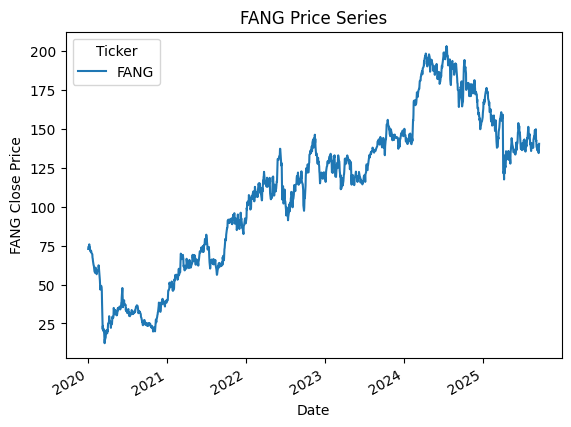

In [27]:
plt.figure(figsize=(10,6))
data['Close'].plot()
plt.ylabel(f"{stocks} Close Price")
plt.title(f"{stocks} Price Series")
plt.show()

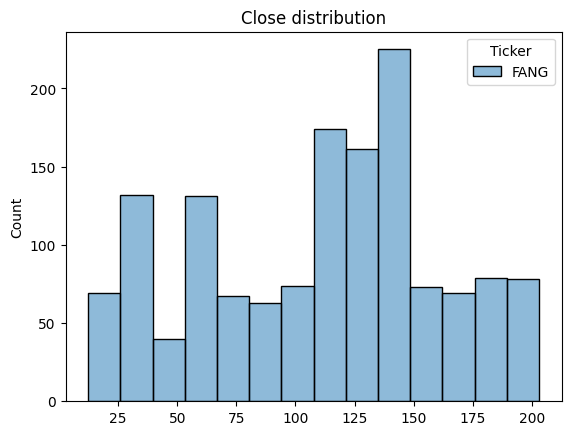

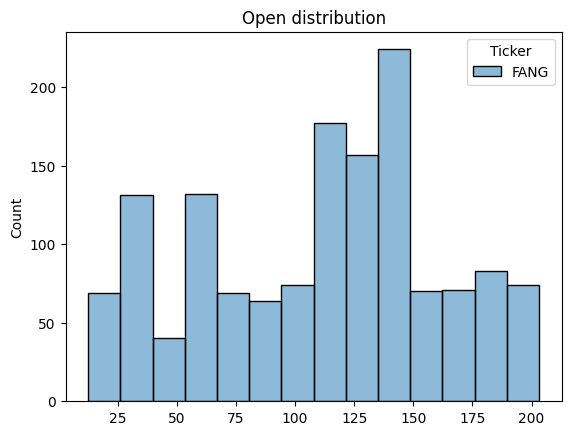

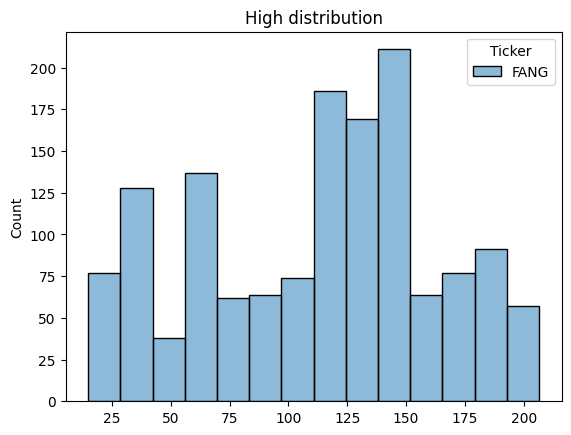

In [28]:
plt.figure(); sns.histplot(data["Close"]); plt.title("Close distribution"); plt.show()
plt.figure(); sns.histplot(data["Open"]); plt.title("Open distribution"); plt.show()
plt.figure(); sns.histplot(data["High"]); plt.title("High distribution"); plt.show()

In [29]:
numeric = data.select_dtypes(include=[np.number])
if 'Close' not in numeric.columns:
    raise KeyError("Close column missing in numeric columns after download/adjust.")
X = numeric.drop(columns = ['Close'])
Y = numeric['Close'] 

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Train shapes:", X_train.shape, Y_train.shape)
print("Test shapes:", X_test.shape, Y_test.shape)

Train shapes: (1148, 4) (1148, 1)
Test shapes: (287, 4) (287, 1)


In [31]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)
def calculate_metrics(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_true, Y_pred)
    return {'mse': mse, 'rmse': rmse, 'r2':r2}
print("Linear Regression metrics:", calculate_metrics(Y_test, lr_pred))

Linear Regression metrics: {'mse': 1.0555125449579765, 'rmse': np.float64(1.0273814018941438), 'r2': 0.9995894142117395}


In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel':['rbf']}
grid = GridSearchCV(SVR(), param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, Y_train)
print("Best params:", grid.best_params_, "Best CV scores:", grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'} Best CV scores: 0.9989659371885695


C:\Users\Khurath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
Y_test

Ticker,FANG
Date,
2022-08-03,103.908173
2021-08-19,56.250881
2021-05-12,65.484200
2025-03-03,144.905426
2021-12-01,85.724602
...,...
2024-02-29,171.085114
2024-01-11,141.905396
2022-01-25,105.682632


In [35]:
best_svr = grid.best_estimator_
svr_pred = best_svr.predict(X_test_scaled)
print("SVR matrics:", calculate_metrics(Y_test, svr_pred))

SVR matrics: {'mse': 2.79969200656209, 'rmse': np.float64(1.6732280198951037), 'r2': 0.9989109425985584}


In [36]:
joblib.dump({'model': best_svr, 'scaler': scaler}, 'svr_model_and_scaler.pkl')
print("Saved model to 'svr_model_and_scaler.pkl'")

Saved model to 'svr_model_and_scaler.pkl'
